The goal is to set up a simple classifier for text and sentiment analysis. The task is the binary classification of movie reviews. The dataset is a part of the *imdb* dataset. You can find the original dataset on the [imdb website](https://www.imdb.com/interfaces/) or a version on the [kaggle website](https://www.kaggle.com/utathya/imdb-review-dataset). For this lab session, we will use a preprocessed version. 


The roadmap is:
- Load, clean and setup the data (in practice this a very important step, for this lab we skip it). 
- Make it suitable for pytorch models
- Define your own model
- Experiments


# The data 

Datasets are available in the cloud repository. There are 2 files, one for positive reviews (imdb.pos) and one for the negative ones (imdb.neg). There are  300000 examples of each class. 

Here two functions to load and clean the data. 

In [ ]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip

th.manual_seed(1) # set the seed 

In [ ]:
import re
import numpy as np
import torch as th
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import random
import math
import pickle
import gzip

th.manual_seed(1) # set the seed

# Data loading 


Load the data : 

In [ ]:
# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'  # avoir enregistré en pickle permet d'avoir les données après processing dans un format simple

# You can download the file with the following line: 
# ! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz

In [ ]:
# find the file imdb.pck.gz, and set the next variable accordingly
filename = 'imdb.pck.gz'

# You can download the file with following line:
! wget "https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA" -O imdb.pck.gz

--2022-04-06 13:30:39--  https://drive.google.com/uc?export=download&id=1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA
Resolving drive.google.com (drive.google.com)... 142.250.148.100, 142.250.148.102, 142.250.148.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.148.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/97skf4cho437v70rv3p1reig2sqmr9fq/1649251800000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download [following]
--2022-04-06 13:30:40--  https://doc-0k-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/97skf4cho437v70rv3p1reig2sqmr9fq/1649251800000/16692574002775380562/*/1199vdCPh5jCMBTWTSM9th0wqMNv2KSvA?e=download
Resolving doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-docs.googleusercontent.com)... 74.125.69.132, 2607:f8b0:4001:c08::84
Connecting to doc-0k-0o-docs.googleusercontent.com (doc-0k-0o-d

Open the data with python and you will get 3 objects : 
- *texts*  : a list of tensors, each tensor represent a word sequence to classify. 
- *labels* : the class, positive or negative, of the corresponding text
- *lexicon*: a dictionnary to map integers to real words


In [ ]:
fp = gzip.open(filename,'rb')
texts , labels, lexicon  = pickle.load(fp)

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)

In [ ]:
fp = gzip.open(filename, 'rb')
#texts, labels, lexison = pickle.load(fp)
texts, labels, lexicon = pickle.load(fp)

print(type(texts), type(labels), type(lexicon))
print(texts[0])
print("nb examples : ", len(texts))
VOCAB_SIZE = len(lexicon)
print("Vocab size: ", VOCAB_SIZE)

<class 'list'> <class 'torch.Tensor'> <class 'dict'>
tensor([ 36,  25, 381,  10,  58,  21,  83])
nb examples :  30000
Vocab size:  5002


Note that a reduced number of words are selected to build the vocabulary. The less frequent words are discarded are replaced by a specific form (*unk* for unknown).


In [ ]:
for i in range(10):
    print("word of index", i , " : ", lexicon[i])

In [ ]:
for i in range(10):
  print("word of index", i, " : ", lexicon[i])

word of index 0  :  <pad>
word of index 1  :  <unk>
word of index 2  :  !
word of index 3  :  the
word of index 4  :  a
word of index 5  :  of
word of index 6  :  movie
word of index 7  :  and
word of index 8  :  this
word of index 9  :  to


To read the text you can use for example the following code: 

In [ ]:
def idx2wordlist(idx_array,lexicon): 
    l = []
    for i in idx_array: 
        l.append(lexicon[i.item()])
    return l
print(texts[0].shape)
print("Some positive reviews")
print("------------")
for i in range(5): 
    print(idx2wordlist(texts[i+50],lexicon))
print("Some negative reviews")
print("------------")
for i in range(5): 
    print(idx2wordlist(texts[-i-2000],lexicon))
    
print("-----------\nA random sentence: ")
print(idx2wordlist(texts[104],lexicon))

torch.Size([7])
Some positive reviews
------------
['strong', 'drama']
['please', 'remake', 'this', 'movie']
['very', 'funny', '!']
['great', 'series']
['fun', 'movie']
Some negative reviews
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']
-----------
A random sentence: 
['you', 'definitely', 'need', 'to', 'see', 'this', 'movie']


In [ ]:
def idx2wordlist(idx_array, lexicon):
  l = []
  for i in idx_array:
    l.append(lexicon[i.item()])
  return l
print(texts[0].shape)
print("Some positive reviews")
print("------------")
for i in range(5):
  print(idx2wordlist(texts[-i-2000], lexicon))

print("-----------\nA random sentence: ")  
print(idx2wordlist(texts[104], lexicon))

torch.Size([7])
Some positive reviews
------------
['absolute', 'waste', 'of', 'time']
['the', 'worst', 'movie', 'ever', 'made']
['slow', 'motion', 'picture', 'that', 'did', "n't", 'get', 'to', 'the', 'point']
['there', 'are', 'good', 'bad', 'movies', 'and', 'there', 'are', 'bad', 'bad', 'movies', 'this', 'one', 'is', 'a', 'real', 'stinker']
['<unk>', 'so', 'bad', 'its', 'funny']
-----------
A random sentence: 
['you', 'definitely', 'need', 'to', 'see', 'this', 'movie']


# Interface data/model

In pratice, we start from raw texts and we need to convert them into word indices. At this step, we can perform text pre-processing, tokenization and data cleaning. In the present case, it is already done. But in real life it is a very important step. 


The goal is to implement a CBOW (Continuous Bag of Words, or a bag of word embeddings) classifier.  This means that the first layer of the model deals with word embeddings. 

The **Embedding** module in pytorch is designed for that purpose. This module expects as input an array or a list of word indices. For this session, the goal is to quickly develop a model. The data interface is therefore rather simple. 
We end this section by creating a labels



# A first model
The first model is a CBOW (Continuous Bag of Words). A text is represented as set of words (a bag of binary features):   
- Each word is associated to its embedding. 
- The text is  represented as the sum of the word embeddings involved. 
- This sum of embeddings is then feed to linear layer with one output unit, 
- followed by the sigmoid activation. The model output is similar to a logistic regression. 

Now we want to code this in pytorch. One way is to first try to build such model (or a toy but similar example) **step by step**, then to create a nice class to wrap everything in a **model**. 

## Building the model, step by step

The input layer of the model is an Embedding layer. This is already implemented in pytorch. Look at the following toy example: 

In [ ]:
# build an Embedding layer
# it is important to understand the parameters given to the constructor ! 
embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=4) # je dis de créer un embedding layer de la taille du lexicon avec une dimension à 4 afin de visualiser
# The dim of 4 is a toy example. 
# run forward on some input
inp = texts[104] # on applique l'embedding layer à une ligne au hasard
embs = embLayer(inp)
# Look at the dimension of i/o
print("The input: ",inp)
print("length: ",len(inp))
print("Embs shape : ",embs.shape)
print(embs)

In [ ]:
# build an Embedding layer : initialisation random
# it is important to understand the parameters given to the constructor !
D=4
embLayer = th.nn.Embedding(num_embeddings=len(lexicon), embedding_dim=D) #4) #je récupère un modèle pytorch avec 5002 vecteurs de taille 4
# The dim of 4 is a toy example.
# run forward on some input
inp = texts[104]
embs = embLayer(inp) # quand j'appelle la fonction forward sur mon entrée, ~ embLayer.forward(inp) car tous les modules pytorch ont une fonction forward : prend les vecteurs (indices ayant remplacés les mots) du tenseur d'entrée auxquels il répond respectivement par les lignes du tenseur de sortie qui sont les embeddings associés
# Look at the dimension of i/o
print("The input; ",inp)
print("length: ",len(inp))
print("Embs shape : ",embs.shape)
print(embs)

The input;  tensor([ 21, 316, 320,   9,  59,   8,   6])
length:  7
Embs shape :  torch.Size([7, 4])
tensor([[-1.4344, -0.5008,  0.1716, -0.1600],
        [ 1.7762,  0.1760,  0.5085, -0.0357],
        [-1.1876, -1.0616,  0.6630, -1.0036],
        [ 0.1991,  0.0457,  0.1530, -0.4757],
        [ 1.7241, -2.3648, -0.9295,  0.2936],
        [ 1.8793, -0.0721,  0.1578, -0.7735],
        [ 1.1017, -0.1759, -2.2456, -1.4465]], grad_fn=<EmbeddingBackward0>)


Now, we want to compress the resulting tensor along the time dimension. This dimension depends on the input texts, while we want to build a fixed-size representation of the sentence. The sum is a first idea. 

In [ ]:
## compute the sum of out to create a vector of size "embedding_dim".
## Of course it will be a tensor with one dimension set to "embedding_dim".
sumOfEmbs = None # TODO 
print(sumOfEmbs.shape) # check the shape 

In [ ]:
## compute the sum of out to create a vector of size "embedding_dim".
## Of course it will be a tensor with one dimension set to "embedding_dim".
sumOfEmbs = embs.sum(dim=0) # la dimension des lignes va être compréssée et disparaitres
# sumOfEmbs = embs.sum() # somme selon les 2 dimensions
print(sumOfEmbs.shape) # check the shape

#sumOfEmbs = embs.sum(dim=1) # somme selon les colonnes donne un vecteur de taille 7, qui n'est pas ce qu'on veut
#print(sumOfEmbs.shape) # check the shape

torch.Size([4])


The final layer is a linear transformation: as input we have a vector of size *embedding_dim* and 1 in output. 
Code this transformation and check the shape of the final result. 

In [ ]:
# Compute out, after you created the Linear layer 
out= None 
print(out.shape)

In [ ]:
# Compute out, after you created the Linear layer 
W = th.nn.Linear(in_features = D, out_features=1) # important de savoir de quelles dimensions on a besoin : la 1ère est la dimension d'entrée, puis celle de sortie, avec éventuellement un vecteur de biais
out_activation = th.nn.Sigmoid() # à chaque construction de couche linéaire, l'initialisation est random car le nombre du tirage aléatoire après le seed est différent
out= out_activation(W(sumOfEmbs)) #th.sigmoid(W(sumOfEmbs)) #None
print(out.shape,out) #)

torch.Size([1]) tensor([0.2945], grad_fn=<SigmoidBackward0>)


##  Wrap everything in a nice module/model

To implement the model, we propose to fill the following class. To write your own module, inherit from the *Module* class. 

In [ ]:
class CBOW_classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        # TODO 
        
    def forward(self, inputs):
        # TODO
        return None 
    
    

In [ ]:
class CBOW_classifier(nn.Module): # classe dont on hérite

  def __init__(self, vocab_size, embedding_dim):
    super(CBOW_classifier, self).__init__() # fait appel à la place mère
    self.emb = nn.Embedding(vocab_size, embedding_dim)
    self.lin =nn.Linear(embedding_dim, 1)#= nn.Linear(embedding_dim, 1)

  def forward(self, inp): #inputs):
    # pour définir la fonction forward, on va reprendre au propre la fonction que l'on vient de faire
    return th.sigmoid(self.lin(self.emb(inp).sum(dim=0))) #None

This class inherits of *Module*. These two methods are mandatory. The constructor build a model with its initialized parameters. The *forward* is for inference.  Reminder: in pytorch, a model takes *Tensors (variables) * and returns *Tensors (variables)*. The output is compared with the gold standard by the loss function. 

Fill this class and make a simple test: take a training example and see if the forward pass is correct. The result should be a *FloatTensor* with one value: the score between 0 and 1 assigned by the model to the example. 


In [ ]:
classifier = CBOW_classifier(vocab_size=len(lexicon),embedding_dim=10)
print(classifier(texts[0]))

tensor([0.1457], grad_fn=<SigmoidBackward0>)


In [ ]:
classifier = CBOW_classifier(vocab_size=len(lexicon), embedding_dim=10)
print(classifier(texts[0]))

tensor([0.8770], grad_fn=<SigmoidBackward0>)


In [ ]:
print(labels[0]) # tenseur qui stocke dans l'autre cas un tenseur scalaire donc mettre à la même dimension? si on ne fait pas mini-batch?

tensor(0.)


In [ ]:
print(classifier.forward(texts[0]))

tensor([0.8770], grad_fn=<SigmoidBackward0>)


## Objective function
The loss (or objective) function is tailored to the model and the task.  

- Read the doc of module **nn** : http://pytorch.org/docs/master/nn.html. 
- In our case, two loss functions can be used:  *BCELoss* and *BCEWithLogitsLoss*. Compare them and make your choice. 
- Given this choice, you may want to modify the class *CBOW_Classifier*. 



In [ ]:
## TODO : define de training function



In [ ]:
# define the training finction
loss_fn = nn.BCELoss() # car sigmoid # peut aussi être mis directement dans la classe # faut cohérence entre loss et réseau

## Training 

Write the code to train your model and monitor the training process and to evaluate the model using test data. Starts with a SGD optimizer with 0.1 as learning rate. 

### Random order
In many cases, in can be important to iter on the data in a random order and not in the order we built the corpus. This initial order can introduce bias in the evaluation process.  A simple method to shuffle the data is to shuffle the indices we use. Assume we have 10 training samples, we can do something like 


In [ ]:
ids = list(range(10))
import random 
random.shuffle(ids)
for i in ids: 
    print(i)

In [ ]:
ids = list(range(10))
import random
random.shuffle(ids)
for i in ids:
  print(i)

6
5
2
0
3
4
7
9
1
8


Now we have everything to run the training loop and test this model. 

In [ ]:
## TODO: training loop




on devrait normalement regarder l'évolution

In [ ]:
total = len(texts)
randomidx = list(range(total))
preds = th.zeros(total)
#optimizer = th.optim.Adam(lr=1e-2) # je défini l'optim pour qu'il prenne tous les params, qui ne bougent pas car sgd?
optimizer = th.optim.SGD(classifier.parameters(),lr=1e-2)
Nepochs = 10
losses = th.zeros(Nepochs)
for epoch in range(Nepochs): #10):
  total_loss = th.Tensor([0]) 
  correct=0
  random.shuffle(randomidx) # parcours aléatoire des données accéléré grâce au parcours de leur indice plutôt
  for i in randomidx:
    classifier.zero_grad() # remet à 0 tout le stockage des grad dans les différents params
    x = texts[i]
    
    probs = classifier(x)[0] # je fais passer un text dans le classifieur pour faire l'inférence : la fonction obj loss attend d'avoir 2 tenseurs qui soient de la même taille
    loss = loss_fn(probs, labels[i]) # loss de la proba que ça ait un bon label
    pred=probs>0.5 # taux de réussite
    preds[i] = pred
    if pred.item() == labels[i].item(): # sur un tenseur, quand on a une valeur, le .item permet de renvoyer un scalaire quoi qu'il advienne : on compare la prédiction au vrai label
      correct += 1
    loss.backward()
    optimizer.step() # pas d'optimisation après la retro du gradient
    total_loss += loss.data
  losses[epoch] = total_loss/total    
  print(epoch, losses[epoch], 100.0*correct/total, preds.sum()) #précision #total_losses[epoch], 100.0*correct/total, preds.sum()) #[epoch], 100.0*correct/total, preds.sum()) #0]/total, 100.0*correct/total, preds.sum())

0 tensor(0.7295) 52.513333333333335 tensor(15052.)
1 tensor(0.6995) 57.653333333333336 tensor(15350.)
2 tensor(0.6656) 61.97666666666667 tensor(15187.)
3 tensor(0.6359) 65.23 tensor(15169.)
4 tensor(0.6147) 67.07666666666667 tensor(14975.)
5 tensor(0.5966) 68.39666666666666 tensor(14993.)
6 tensor(0.5781) 69.98666666666666 tensor(14842.)
7 tensor(0.5638) 71.18 tensor(14980.)
8 tensor(0.5514) 72.00333333333333 tensor(14895.)
9 tensor(0.5397) 72.89333333333333 tensor(14902.)


on commence un peu mieux qu'une chance sur 2

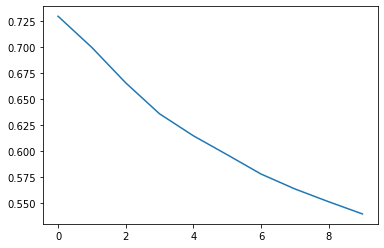

In [ ]:
import matplotlib.pyplot as plt
plt.plot(losses)

# First Experiments

- Make experiments  with  2000 to start then all the data for training (equally distributed between positive and negative examples). 
- You should create a development and test sets. 
- Test different parametrization of the model (here the embedding size) and the hyper-parameter (the learning rate) for each setups. 
- Compare these different setups (loss function on the train and also the classification accuracy). 



# A deeper model

We can add a hidden layer to the previous classifier. 
- Do the same as before with the different setups
- Find the good choice of hyper-parameters.  

